In [77]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, GaussianNoise, Reshape
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import jupyterthemes as jt
from sklearn.model_selection import train_test_split
from datetime import datetime

jt.jtplot.style()

""" Avoid error with Blas:GEMM not initializing when using GPU:
See: https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
"""
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(98)
np.random.seed(99)

In [119]:
def rounding_accuracy(y_true, y_pred):
    """Rounds both target and output to 0,1 and calculates the accuracy"""
    round_true = tf.math.round(y_true)
    round_preds = tf.math.round(y_pred)
    return tf.metrics.binary_accuracy(round_true, round_preds)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_history(history, acc="rounding_accuracy"):
    loss, val_loss = history["loss"], history["val_loss"]
    acc, val_acc = history[acc], history[f"val_{acc}"]
    n_epochs = range(len(loss))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    
    ax1.plot(n_epochs, loss, label="train")
    ax1.plot(n_epochs, val_loss, label="validation")
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.legend()

    ax2.plot(n_epochs, acc, label="train")
    ax2.plot(n_epochs, val_acc, label="validation")
    ax2.set_ylabel("accuracy")
    ax2.legend()

    plt.show()


# Exercise 9
## Try using a denoising autoencoder to pre-train an image classifier
### a) Use MNIST (simplest option)
### b) Use CIFAR-10 (bigger challenge)

In [81]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

train_size = 55000

X_train_scaled, X_test_scaled = X_train_full / 255., X_test_full / 255.
X_train, y_train = X_train_full[:train_size], y_train_full[:train_size]
X_valid, y_valid = X_train_full[train_size:], y_train_full[train_size:]

### Denoising Autoencoder

In [115]:
codings_size = 50
batch_size = 32

encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    GaussianNoise(0.3),
    Dense(100, activation="selu"),
    Dense(codings_size, activation="selu")
])
decoder = Sequential([
    Dense(100, activation="selu", input_shape=[codings_size]),
    Dense(28*28, activation="sigmoid"),
    Reshape([28, 28])
])
model = Sequential([encoder, decoder])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounding_accuracy])
history = model.fit(X_train_scaled, X_train_scaled,
                    validation_data=(X_test_scaled, X_test_scaled),
                    batch_size=32,
                    epochs=6)

Epoch 1/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1870 - rounding_accuracy: 0.9166 - val_loss: 0.1028 - val_rounding_accuracy: 0.9647
Epoch 2/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1123 - rounding_accuracy: 0.9587 - val_loss: 0.0946 - val_rounding_accuracy: 0.9696
Epoch 3/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1068 - rounding_accuracy: 0.9617 - val_loss: 0.0925 - val_rounding_accuracy: 0.9709
Epoch 4/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1048 - rounding_accuracy: 0.9629 - val_loss: 0.0905 - val_rounding_accuracy: 0.9722
Epoch 5/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1031 - rounding_accuracy: 0.9640 - val_loss: 0.0892 - val_rounding_accuracy: 0.9730
Epoch 6/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1016 - rounding_accuracy: 0.9648 - val_loss: 0.0885 - val_rounding_accuracy: 0.9733


In [98]:
history = history.history

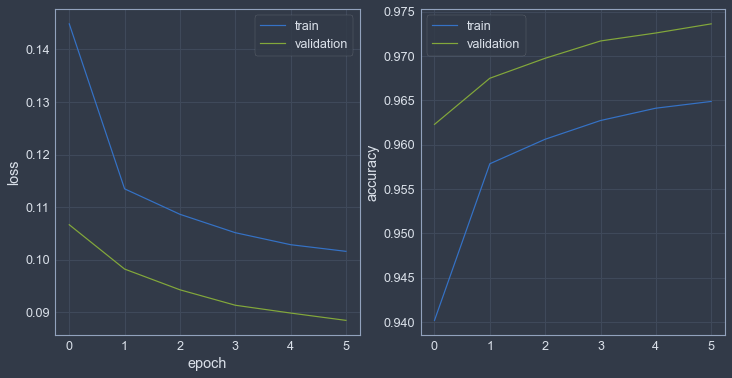

In [105]:
plot_history(history)

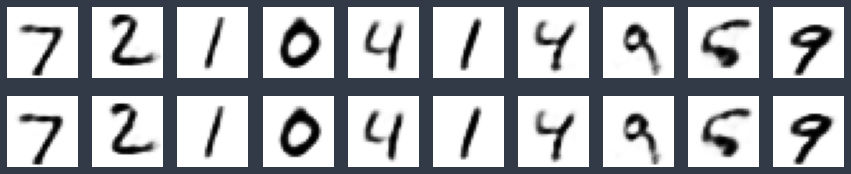

In [89]:
images = model.predict(X_test_scaled)
show_reconstructions(model, images, 10)

### Classifier trained on small sample

In [110]:
X_train_sample = X_train[:500]
y_train_sample = y_train[:500]

In [116]:
classifier = Sequential([
    encoder,
    Dense(100, activation="selu"),
    Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = classifier.fit(
    X_train_sample, y_train_sample, 
    validation_data=(X_valid, y_valid),
    epochs=20, batch_size=16)

Epoch 1/20
32/32 [==============================] - 1s 30ms/step - loss: 595.7303 - accuracy: 0.2017 - val_loss: 120.7376 - val_accuracy: 0.5540
Epoch 2/20
32/32 [==============================] - 1s 24ms/step - loss: 82.3152 - accuracy: 0.6354 - val_loss: 66.1348 - val_accuracy: 0.6878
Epoch 3/20
32/32 [==============================] - 1s 25ms/step - loss: 29.8887 - accuracy: 0.8469 - val_loss: 53.8711 - val_accuracy: 0.7122
Epoch 4/20
32/32 [==============================] - 1s 26ms/step - loss: 17.0935 - accuracy: 0.8627 - val_loss: 50.6519 - val_accuracy: 0.7350
Epoch 5/20
32/32 [==============================] - 1s 25ms/step - loss: 8.0071 - accuracy: 0.9258 - val_loss: 44.4507 - val_accuracy: 0.7472
Epoch 6/20
32/32 [==============================] - 1s 27ms/step - loss: 3.9841 - accuracy: 0.9419 - val_loss: 41.2700 - val_accuracy: 0.7568
Epoch 7/20
32/32 [==============================] - 1s 26ms/step - loss: 1.3751 - accuracy: 0.9814 - val_loss: 40.7639 - val_accuracy: 0.7572


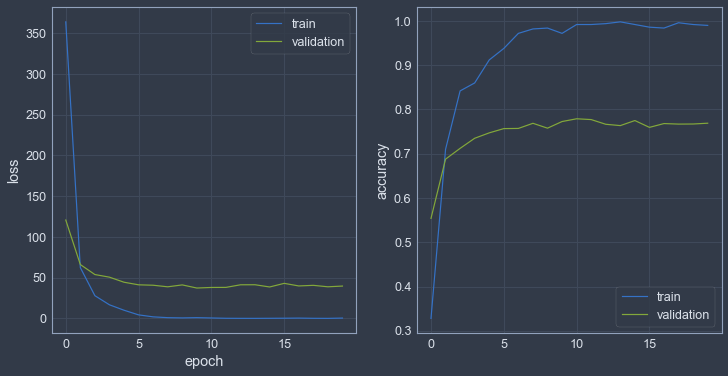

In [120]:
plot_history(history.history, "accuracy")